In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv("../../data/ml-100k/ub.base", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])
df_test = pd.read_csv("../../data/ml-100k/ub.test", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])


In [3]:
df_items = pd.read_csv("../../data/ml-100k/u.item", sep="|", 
                 header=None, encoding='latin-1',
                 names=["movie id", "movie title", "release date", "video release date",
                        "IMDb URL", "unknown", "Action", "Adventure", "Animation",
                        "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                        "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                        "Thriller", "War", "Western"])

In [4]:
pivoted_users_train = pd.pivot(df_train, index='user id', columns='item id', values='rating')

In [5]:
genres_matrix = (
    df_items
    [df_items['movie id'].isin(pivoted_users_train.index)]
    .set_index('movie id')
    .drop(["movie title", "release date", "video release date", "IMDb URL"], axis=1)
)

In [6]:
train_dataset = df_train.merge(
    df_items
    .drop(["movie title", "release date", "video release date", "IMDb URL"], axis=1)
    .rename(columns={"movie id": "item id"})
)

test_dataset = df_test.merge(
    df_items
    .drop(["movie title", "release date", "video release date", "IMDb URL"], axis=1)
    .rename(columns={"movie id": "item id"})
)

In [7]:
def train_model(group):
    return Lasso(alpha=1.0, max_iter=10000).fit(
        group.drop(["user id", "item id", "rating", "timestamp"], axis=1),
        group["rating"]
    )

In [8]:
models = train_dataset.groupby("user id").apply(train_model).to_dict()

In [9]:
ratings_train = train_dataset.groupby("user id")['rating'].apply(list)

predictions_train = train_dataset.groupby("user id").apply(
    lambda x: [x['user id'].iloc[0], x['item id'].count(), models[x["user id"].iloc[0]]
              .predict(x.drop(["user id", "item id", "rating", "timestamp"], axis=1))],
)

errors_train = []
for v, p in zip(ratings_train, predictions_train):
    errors_train += [[p[0], p[1], mean_squared_error(v, p[2], squared=False)]]
    
errors_train_df = pd.DataFrame(errors_train, columns=['user_id', 'size_train', 'error_train'])

In [10]:
ratings_test = test_dataset.groupby("user id")['rating'].apply(list)

predictions_test = test_dataset.groupby("user id").apply(
    lambda x: [x['user id'].iloc[0], x['item id'].count(), models[x["user id"].iloc[0]]
              .predict(x.drop(["user id", "item id", "rating", "timestamp"], axis=1))],
)

errors_test = []
for v, p in zip(ratings_test, predictions_test):
    errors_test +=  [[p[0], p[1], mean_squared_error(v, p[2], squared=False)]]
    
errors_test_df = pd.DataFrame(errors_test, columns=['user_id', 'size_test', 'error_test'])

<AxesSubplot:xlabel='size_train', ylabel='error_train'>

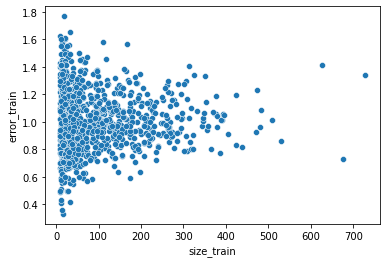

In [11]:
sns.scatterplot(data=errors_train_df, x='size_train', y='error_train')

In [12]:
errors_df = errors_train_df.merge(errors_test_df)

<AxesSubplot:xlabel='size_train', ylabel='error_test'>

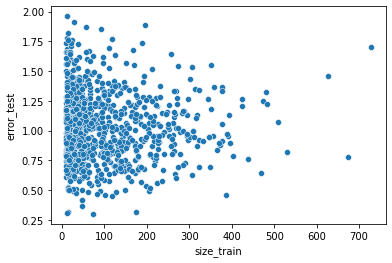

In [13]:
sns.scatterplot(data=errors_df,
                x='size_train', y='error_test')

In [14]:
errors_df['error_train'].mean(), errors_df['error_test'].mean()

(1.002352389202647, 1.020684190448083)